# **Installations**

In [3]:
!pip install gradio --quiet

# **Import Libraries**

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sentencepiece as sp
import math
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader


# **Create Embedding Layer**

In [5]:
class TokenEmbedding(nn.Module):

  def __init__(self , vocab_size , embed_size):

    super().__init__()
    self.Embedding = nn.Embedding(vocab_size , embed_size)
    self.embed_size = embed_size

  def forward(self , x):
      #scaling - need ?
      ## Initailly the embedding values are randomly assigned , which are small numbers so they have low variance and if such value are
      #passed to the transformer , then then vanish gradient problem could occur , to avoid this issue embeddings are scaled .

      scaled_embedding = self.Embedding(x) * torch.sqrt(torch.tensor(self.embed_size , dtype=torch.float32))
      return scaled_embedding



## **Instantiate the object of Embedding layer and test a smaple**

In [6]:
vocab_size = 8000
embed_size = 512

embedding_layer = TokenEmbedding(vocab_size , embed_size)

sample_batch = torch.tensor([
    [12 , 34 , 56 , 78 , 90],
    [89 , 69 , 78 , 35 , 12]
])

embeddings = embedding_layer(sample_batch)

In [7]:
embeddings

tensor([[[ 11.0408,  25.4717,  62.7029,  ...,  36.0221,   9.3135,  47.4789],
         [ 24.7087,  12.9996,  10.7431,  ...,  -8.7816, -30.5586, -32.1402],
         [-17.7497, -16.7081, -21.5427,  ..., -21.1227, -12.5065,  13.3465],
         [ 30.2456,  -5.4774,   1.9471,  ...,   6.0165,   1.7800,  -7.6457],
         [  1.9305, -11.8534,  -0.6195,  ..., -21.4637, -27.1476,   6.8110]],

        [[ 43.2353,  -4.0131,   2.3855,  ...,  12.3322,   8.4963,   5.2875],
         [ -6.2122, -25.8902,   1.6342,  ...,  41.4685,  10.3077,  63.1995],
         [ 30.2456,  -5.4774,   1.9471,  ...,   6.0165,   1.7800,  -7.6457],
         [-22.5134,  -3.0646, -41.4655,  ..., -58.4634,  16.6359,  14.5144],
         [ 11.0408,  25.4717,  62.7029,  ...,  36.0221,   9.3135,  47.4789]]],
       grad_fn=<MulBackward0>)

In [8]:
embeddings.shape ##Two sentences , 5 words , each one is 512 dimension

torch.Size([2, 5, 512])

In [9]:
embeddings[0].shape

torch.Size([5, 512])

In [10]:
embeddings[0][0].shape

torch.Size([512])

## **Integrate with Tokenizer Output**

## **Import Tokenizer Model**

In [11]:
sp_en = sp.SentencePieceProcessor()
sp_en.load("/content/drive/MyDrive/Dataset/Machine_Translation_model/spm_en.model")

True

In [12]:
sample_text = "Thala for a reason"
ids = sp_en.encode(sample_text , out_type = int)

In [13]:
sp_en.encode(sample_text , out_type=str)

['▁Th', 'al', 'a', '▁for', '▁a', '▁reason']

In [14]:
ids

[358, 40, 7903, 79, 10, 4761]

In [15]:
input_sequence = torch.tensor([ids])
print(input_sequence)
print(input_sequence.shape)

tensor([[ 358,   40, 7903,   79,   10, 4761]])
torch.Size([1, 6])


In [16]:
sample_embedding = embedding_layer(input_sequence)

In [17]:
sample_embedding

tensor([[[ -9.1725,  -4.5870,  20.5672,  ..., -27.3445, -35.9609,   2.7045],
         [-21.7542,   4.3257,  10.4511,  ..., -29.8129,  14.8443,  25.0914],
         [-39.2807, -13.9733,  37.5808,  ...,   6.7425, -21.5184,  -6.4712],
         [ -7.5993,   2.6059,  30.7830,  ...,  13.9835,  43.3788, -10.3348],
         [ 11.7911,  18.9326, -50.5244,  ..., -43.6076,   4.7074, -23.0471],
         [-15.5428,  -5.8331,  22.6786,  ..., -23.0407, -11.5493, -17.3826]]],
       grad_fn=<MulBackward0>)

In [18]:
print(sample_embedding.shape)

torch.Size([1, 6, 512])


## **Visualize Embeddings (for intuition)**

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sample_text="I love playing football coding"

tokens = torch.tensor([sp_en.piece_to_id(word) for word in sample_text.split()]).unsqueeze(0)
print(tokens)
embedding_result = embedding_layer(tokens)
print(embedding_result)
print(embedding_result.shape)

tensor([[7934,    0,    0,    0,    0]])
tensor([[[ 29.0710,  44.5532, -23.0729,  ..., -42.7995,  13.3480, -32.0280],
         [  2.0307,   1.7555, -21.6802,  ..., -35.7687, -22.9897, -15.5765],
         [  2.0307,   1.7555, -21.6802,  ..., -35.7687, -22.9897, -15.5765],
         [  2.0307,   1.7555, -21.6802,  ..., -35.7687, -22.9897, -15.5765],
         [  2.0307,   1.7555, -21.6802,  ..., -35.7687, -22.9897, -15.5765]]],
       grad_fn=<MulBackward0>)
torch.Size([1, 5, 512])


In [20]:
detached_results = embedding_result.detach().numpy()

In [21]:
detached_results

array([[[ 29.071    ,  44.553185 , -23.072935 , ..., -42.79953  ,
          13.348008 , -32.02796  ],
        [  2.0307252,   1.7555193, -21.680191 , ..., -35.76868  ,
         -22.98968  , -15.576459 ],
        [  2.0307252,   1.7555193, -21.680191 , ..., -35.76868  ,
         -22.98968  , -15.576459 ],
        [  2.0307252,   1.7555193, -21.680191 , ..., -35.76868  ,
         -22.98968  , -15.576459 ],
        [  2.0307252,   1.7555193, -21.680191 , ..., -35.76868  ,
         -22.98968  , -15.576459 ]]], dtype=float32)

In [22]:
detached_results = detached_results.squeeze(0)

In [23]:
detached_results

array([[ 29.071    ,  44.553185 , -23.072935 , ..., -42.79953  ,
         13.348008 , -32.02796  ],
       [  2.0307252,   1.7555193, -21.680191 , ..., -35.76868  ,
        -22.98968  , -15.576459 ],
       [  2.0307252,   1.7555193, -21.680191 , ..., -35.76868  ,
        -22.98968  , -15.576459 ],
       [  2.0307252,   1.7555193, -21.680191 , ..., -35.76868  ,
        -22.98968  , -15.576459 ],
       [  2.0307252,   1.7555193, -21.680191 , ..., -35.76868  ,
        -22.98968  , -15.576459 ]], dtype=float32)

In [24]:
detached_results.shape

(5, 512)

In [25]:
pca =PCA(n_components=2)
points = pca.fit_transform(detached_results)

In [26]:
plt.figure(figsize=(6,6))
plt.scatter(points[: , 0] , points[:  , 1])
for i , word in enumerate(sample_text.split()):
  plt.text(points[i , 0]+0.01 , points[i , 1]+0.01 , word)
plt.title("Word Embeddings (2D PCA Projection)")
plt.show()

ValueError: Image size of 534x85215083 pixels is too large. It must be less than 2^23 in each direction.

<Figure size 600x600 with 1 Axes>

tensor([[  73,   68,  121, 3341,   14, 2414, 7916,  219,   15, 2265]])
torch.Size([1, 10])
torch.Size([1, 10, 512])
(1, 10, 512)
(10, 512)


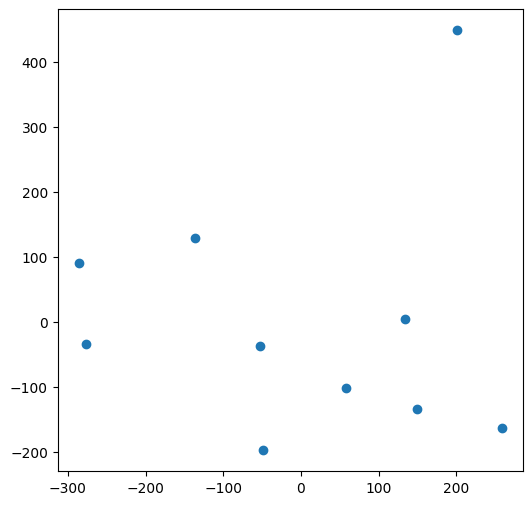

In [27]:
id_list = sp_en.encode("I love playing football coding" , out_type=int)
id_list = torch.tensor(id_list).unsqueeze(0)
print(id_list)
print(id_list.shape)

embedding_ids = embedding_layer(id_list)
print(embedding_ids.shape)

store = embedding_ids.detach().numpy()
print(store.shape)

store = store.squeeze(0)
print(store.shape)

pca1=PCA(n_components=2)
data = pca1.fit_transform(store)
data

plt.figure(figsize=(6,6))
plt.scatter(data[: , 0]  , data[: , 1])
for i , word in enumerate(data):
  plt.plot(data[i , 0]+0.01 , data[i , 1]+0.01)

# **Positional Encoding**

## **Implementation**

In [28]:
class PositionalEncoding(nn.Module):

    def __init__(self , d_model , max_len=5000):

      super().__init__()

      pe = torch.zeros(max_len , d_model)
      position = torch.arange(0 , max_len , dtype=torch.float).unsqueeze(1)

      div_term = torch.exp(torch.arange(0 , d_model , 2).float() * (-math.log(10000.0)/d_model))

      pe[: , 0::2] = torch.sin(position * div_term)
      pe[: , 1::2] = torch.cos(position * div_term)

      pe = pe.unsqueeze(0)


      self.register_buffer('pe' , pe)

    def forward(self , x):

      seq_len = x.size(1)
      x = x + self.pe[: , :seq_len]
      return x



In [29]:
d_model = 512
seq_len = 50
batch_size = 2

# Create dummy embedding output
sample_embeddings = torch.zeros(batch_size, seq_len, d_model)

# Add positional encodings
pos_encoder = PositionalEncoding(d_model)
encoded = pos_encoder(sample_embeddings)

print("Shape after positional encoding:", encoded.shape)

Shape after positional encoding: torch.Size([2, 50, 512])


## **Positional Encoding in detail**

In [30]:
d_model = 512
seq_len = 50
batch_size = 2
max_len=5000

In [31]:
torch.arange(0 , d_model , 2).float()

tensor([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
         24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,  46.,
         48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,  68.,  70.,
         72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,  90.,  92.,  94.,
         96.,  98., 100., 102., 104., 106., 108., 110., 112., 114., 116., 118.,
        120., 122., 124., 126., 128., 130., 132., 134., 136., 138., 140., 142.,
        144., 146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180., 182., 184., 186., 188., 190.,
        192., 194., 196., 198., 200., 202., 204., 206., 208., 210., 212., 214.,
        216., 218., 220., 222., 224., 226., 228., 230., 232., 234., 236., 238.,
        240., 242., 244., 246., 248., 250., 252., 254., 256., 258., 260., 262.,
        264., 266., 268., 270., 272., 274., 276., 278., 280., 282., 284., 286.,
        288., 290., 292., 294., 296., 29

In [32]:
div_term = torch.exp(torch.arange(0 , d_model , 2).float() * (-math.log(10000.0) / d_model))

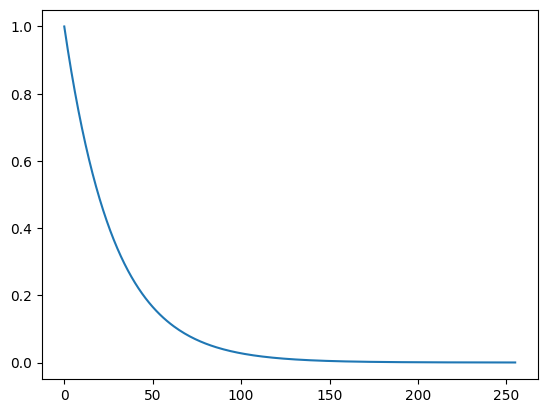

In [33]:
plt.plot(div_term.numpy())

In [34]:
pe = torch.zeros(max_len , d_model)

In [35]:
pe.shape

torch.Size([5000, 512])

In [36]:
pe[: , 0::2].shape  #even index

torch.Size([5000, 256])

In [37]:
pe[0:, 1::2].shape #odd index

torch.Size([5000, 256])

In [38]:
position = torch.arange(0 , max_len , dtype=torch.float).unsqueeze(1)

In [39]:
position

tensor([[0.0000e+00],
        [1.0000e+00],
        [2.0000e+00],
        ...,
        [4.9970e+03],
        [4.9980e+03],
        [4.9990e+03]])

In [40]:
position.shape

torch.Size([5000, 1])

In [41]:
div_term

tensor([1.0000e+00, 9.6466e-01, 9.3057e-01, 8.9769e-01, 8.6596e-01, 8.3536e-01,
        8.0584e-01, 7.7737e-01, 7.4989e-01, 7.2339e-01, 6.9783e-01, 6.7317e-01,
        6.4938e-01, 6.2643e-01, 6.0430e-01, 5.8294e-01, 5.6234e-01, 5.4247e-01,
        5.2330e-01, 5.0481e-01, 4.8697e-01, 4.6976e-01, 4.5316e-01, 4.3714e-01,
        4.2170e-01, 4.0679e-01, 3.9242e-01, 3.7855e-01, 3.6517e-01, 3.5227e-01,
        3.3982e-01, 3.2781e-01, 3.1623e-01, 3.0505e-01, 2.9427e-01, 2.8387e-01,
        2.7384e-01, 2.6416e-01, 2.5483e-01, 2.4582e-01, 2.3714e-01, 2.2876e-01,
        2.2067e-01, 2.1288e-01, 2.0535e-01, 1.9810e-01, 1.9110e-01, 1.8434e-01,
        1.7783e-01, 1.7154e-01, 1.6548e-01, 1.5963e-01, 1.5399e-01, 1.4855e-01,
        1.4330e-01, 1.3824e-01, 1.3335e-01, 1.2864e-01, 1.2409e-01, 1.1971e-01,
        1.1548e-01, 1.1140e-01, 1.0746e-01, 1.0366e-01, 1.0000e-01, 9.6466e-02,
        9.3057e-02, 8.9769e-02, 8.6596e-02, 8.3536e-02, 8.0584e-02, 7.7736e-02,
        7.4989e-02, 7.2339e-02, 6.9783e-

In [42]:
result = position * div_term

In [43]:
result

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 9.6466e-01, 9.3057e-01,  ..., 1.1140e-04, 1.0746e-04,
         1.0366e-04],
        [2.0000e+00, 1.9293e+00, 1.8611e+00,  ..., 2.2279e-04, 2.1492e-04,
         2.0733e-04],
        ...,
        [4.9970e+03, 4.8204e+03, 4.6501e+03,  ..., 5.5665e-01, 5.3698e-01,
         5.1801e-01],
        [4.9980e+03, 4.8214e+03, 4.6510e+03,  ..., 5.5676e-01, 5.3709e-01,
         5.1811e-01],
        [4.9990e+03, 4.8223e+03, 4.6519e+03,  ..., 5.5688e-01, 5.3720e-01,
         5.1821e-01]])

In [44]:
result.shape

torch.Size([5000, 256])

In [45]:
position.shape

torch.Size([5000, 1])

In [46]:
div_term.shape

torch.Size([256])

In [47]:
result.shape

torch.Size([5000, 256])

In [48]:
result

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 9.6466e-01, 9.3057e-01,  ..., 1.1140e-04, 1.0746e-04,
         1.0366e-04],
        [2.0000e+00, 1.9293e+00, 1.8611e+00,  ..., 2.2279e-04, 2.1492e-04,
         2.0733e-04],
        ...,
        [4.9970e+03, 4.8204e+03, 4.6501e+03,  ..., 5.5665e-01, 5.3698e-01,
         5.1801e-01],
        [4.9980e+03, 4.8214e+03, 4.6510e+03,  ..., 5.5676e-01, 5.3709e-01,
         5.1811e-01],
        [4.9990e+03, 4.8223e+03, 4.6519e+03,  ..., 5.5688e-01, 5.3720e-01,
         5.1821e-01]])

In [49]:
pe[: , 0::2 ] = torch.sin(position * div_term)
pe[: , 1::2 ] = torch.cos(position * div_term)

In [50]:
pe

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
          1.0366e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
          2.0733e-04,  1.0000e+00],
        ...,
        [ 9.5625e-01, -2.9254e-01,  9.3594e-01,  ...,  8.5926e-01,
          4.9515e-01,  8.6881e-01],
        [ 2.7050e-01, -9.6272e-01,  8.2251e-01,  ...,  8.5920e-01,
          4.9524e-01,  8.6876e-01],
        [-6.6395e-01, -7.4778e-01,  1.4615e-03,  ...,  8.5915e-01,
          4.9533e-01,  8.6871e-01]])

In [51]:
pe.shape

torch.Size([5000, 512])

In [52]:
pe = pe.unsqueeze(0)

In [53]:
pe

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 9.5625e-01, -2.9254e-01,  9.3594e-01,  ...,  8.5926e-01,
           4.9515e-01,  8.6881e-01],
         [ 2.7050e-01, -9.6272e-01,  8.2251e-01,  ...,  8.5920e-01,
           4.9524e-01,  8.6876e-01],
         [-6.6395e-01, -7.4778e-01,  1.4615e-03,  ...,  8.5915e-01,
           4.9533e-01,  8.6871e-01]]])

In [54]:
pe.shape

torch.Size([1, 5000, 512])

In [55]:
import numpy as np

arr = np.arange(1 , 100)
print(arr)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


In [56]:
ls = list([0,1,2,3,4,5,6])

In [57]:
ls[0::2]

[0, 2, 4, 6]

In [58]:
ls[1::2]

[1, 3, 5]

In [59]:
pe.shape

torch.Size([1, 5000, 512])

In [60]:
pe[: , :seq_len].shape

torch.Size([1, 50, 512])

In [61]:
positional_encoding_vector = pe[: , :50]
print(positional_encoding_vector)
print(positional_encoding_vector.shape)

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 1.2357e-01, -9.9234e-01,  9.7719e-01,  ...,  9.9999e-01,
           4.8722e-03,  9.9999e-01],
         [-7.6825e-01, -6.4014e-01,  7.3124e-01,  ...,  9.9999e-01,
           4.9758e-03,  9.9999e-01],
         [-9.5375e-01,  3.0059e-01, -1.4402e-01,  ...,  9.9999e-01,
           5.0795e-03,  9.9999e-01]]])
torch.Size([1, 50, 512])


In [62]:
embedding = torch.zeros(1 , 50 , 512) #1 sentence with 50 words and each word is of 512 dimension
print(embedding)
print(embedding.shape)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 50, 512])


In [63]:
final_embedding = embedding + positional_encoding_vector

In [64]:
print(final_embedding)
print(final_embedding.shape)

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 1.2357e-01, -9.9234e-01,  9.7719e-01,  ...,  9.9999e-01,
           4.8722e-03,  9.9999e-01],
         [-7.6825e-01, -6.4014e-01,  7.3124e-01,  ...,  9.9999e-01,
           4.9758e-03,  9.9999e-01],
         [-9.5375e-01,  3.0059e-01, -1.4402e-01,  ...,  9.9999e-01,
           5.0795e-03,  9.9999e-01]]])
torch.Size([1, 50, 512])


In [65]:
## Calling the embedding layer
seq_len_internal_cal = embedding.size(1)
print(seq_len_internal_cal)

50


## **Positional Encoding Testing**

In [66]:
d_model = 512
seq_len = 50
batch_size = 2

embedding = torch.zeros(batch_size , seq_len , d_model)

pos_encoding = PositionalEncoding(d_model)
encoded = pos_encoding(embedding)

print(encoded)
print(encoded.shape)


tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 1.2357e-01, -9.9234e-01,  9.7719e-01,  ...,  9.9999e-01,
           4.8722e-03,  9.9999e-01],
         [-7.6825e-01, -6.4014e-01,  7.3124e-01,  ...,  9.9999e-01,
           4.9758e-03,  9.9999e-01],
         [-9.5375e-01,  3.0059e-01, -1.4402e-01,  ...,  9.9999e-01,
           5.0795e-03,  9.9999e-01]],

        [[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 1.2357e-01, -9

## **Visualize the positional encoding**

In [67]:
plt.figure(figsize=(12 , 6))

pe = pos_encoding.pe[0 , :100 , :].detach().numpy()
pe.shape

(100, 512)

<Figure size 1200x600 with 0 Axes>

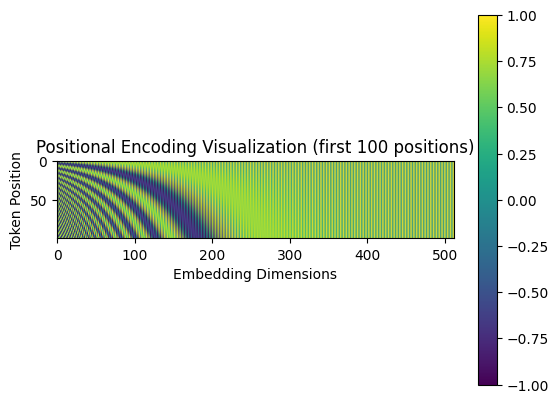

In [68]:
plt.imshow(pe , cmap='viridis')
plt.xlabel("Embedding Dimensions")
plt.ylabel("Token Position")
plt.title("Positional Encoding Visualization (first 100 positions)")
plt.colorbar()
plt.show()

## **Combine with Sample Token Embeddings**

In [69]:
vocab_size = 8000
embed_dim = 512

embed = TokenEmbedding(vocab_size , embed_dim)
pos_encoding = PositionalEncoding(embed_dim)

In [70]:
sample_tokens = torch.randint(0, vocab_size, (2, 10))
print(sample_tokens)
print(sample_tokens.shape)

tensor([[1643, 1342, 2401, 4745, 1661, 7296, 5983, 5226, 5658, 5465],
        [2564, 1690, 4270,  140, 3073, 4134, 5342, 3744, 1576, 3987]])
torch.Size([2, 10])


In [71]:
word_embedding = embed(sample_tokens)
print(word_embedding)
print(word_embedding.shape)

tensor([[[-72.7352, -31.0104,  20.5326,  ...,  35.6443,  23.8550,  18.9281],
         [ -7.6820,  -2.3125,  -3.1167,  ...,   9.1874, -29.7193,  15.3537],
         [  5.7490,  -5.0533, -28.0158,  ..., -17.2350,  17.3463,  27.0595],
         ...,
         [ 25.9949,  -8.8576, -23.6226,  ..., -47.5446,  29.9243,  -5.7624],
         [  9.3263,  19.0122,   0.6402,  ...,  -1.5587,   0.7707,  18.9532],
         [ 24.8193, -26.1566,  -7.7038,  ...,  36.4646, -13.0466, -23.7225]],

        [[-17.5973, -21.8204,  23.7980,  ...,  -8.9155,  25.0441,  -8.5475],
         [-26.8944,  15.1318,   2.6239,  ...,  32.4713,  14.9592, -12.9957],
         [ 12.8780, -28.9352, -11.7285,  ...,  -2.5179,  59.6463,   4.4541],
         ...,
         [ 45.7268, -26.1374,  -0.6725,  ..., -42.7059,   4.7743, -36.0856],
         [-44.3458,  28.7377,  -7.3831,  ...,   9.3814,  18.8068,  24.6281],
         [-33.5816,  32.8730, -14.1740,  ...,  14.5121,  55.1729,  21.6185]]],
       grad_fn=<MulBackward0>)
torch.Size([2

In [72]:
final_output = pos_encoding(word_embedding)
print(final_output)
print(final_output.shape)

tensor([[[-72.7352, -30.0104,  20.5326,  ...,  36.6443,  23.8550,  19.9281],
         [ -6.8406,  -1.7722,  -2.2949,  ...,  10.1874, -29.7192,  16.3537],
         [  6.6583,  -5.4694, -27.0793,  ..., -16.2350,  17.3465,  28.0595],
         ...,
         [ 26.6519,  -8.1037, -23.1702,  ..., -46.5446,  29.9250,  -4.7624],
         [ 10.3156,  18.8667,   1.6309,  ...,  -0.5587,   0.7715,  19.9532],
         [ 25.2314, -27.0678,  -7.0274,  ...,  37.4646, -13.0457, -22.7225]],

        [[-17.5973, -20.8204,  23.7980,  ...,  -7.9155,  25.0441,  -7.5475],
         [-26.0530,  15.6721,   3.4458,  ...,  33.4713,  14.9593, -11.9957],
         [ 13.7873, -29.3514, -10.7921,  ...,  -1.5179,  59.6465,   5.4541],
         ...,
         [ 46.3838, -25.3835,  -0.2201,  ..., -41.7059,   4.7751, -35.0856],
         [-43.3564,  28.5922,  -6.3924,  ...,  10.3814,  18.8076,  25.6281],
         [-33.1695,  31.9618, -13.4976,  ...,  15.5121,  55.1738,  22.6185]]],
       grad_fn=<AddBackward0>)
torch.Size([2

## **Combine Tokenizer -> Word Embedding -> Positional Enconding**

In [73]:
vocab_size = 8000
embed_size = 512

#Import Trained tokenizer
sp_en = sp.SentencePieceProcessor()
sp_en.load('/content/drive/MyDrive/Dataset/Machine_Translation_model/spm_en.model')

print("Text To Tokens")
print("Text : Thala for a reason")
print("Text to tokens: " , sp_en.encode("Thala for a reason" , out_type=str))
text_to_ids = sp_en.encode("Thala for a reason" , out_type=int)
input_seq = torch.tensor([text_to_ids])
print("Tokens to IDs: " , input_seq)
print("Shape: " , input_seq.shape)

print("*"*100)
print("Word Embeddings")
embedding_layer_1 = TokenEmbedding(vocab_size , embed_size)
print(embedding_layer_1)
word_embedding = embedding_layer_1(input_seq)
print("Word Embedding: ", word_embedding)
print("Shape: ", word_embedding.shape)

print("*"*100)
print("Positional Encoding")
positional_encoding = PositionalEncoding(embed_size)
final_embedding = positional_encoding(word_embedding)
print("Final Embedding : " ,final_embedding)
print("Shape : " , final_embedding.shape)

Text To Tokens
Text : Thala for a reason
Text to tokens:  ['▁Th', 'al', 'a', '▁for', '▁a', '▁reason']
Tokens to IDs:  tensor([[ 358,   40, 7903,   79,   10, 4761]])
Shape:  torch.Size([1, 6])
****************************************************************************************************
Word Embeddings
TokenEmbedding(
  (Embedding): Embedding(8000, 512)
)
Word Embedding:  tensor([[[-39.4582, -20.3159,  -5.2787,  ...,  27.8871,  23.9152,  11.5742],
         [-23.6045,  12.2518,  -8.8534,  ...,  46.1722,  -8.3936, -38.8191],
         [  5.6913, -14.6060,  26.6086,  ..., -36.8980,  21.0452,  27.0226],
         [ -2.7533,   2.3354, -14.0119,  ...,  20.1193,   1.0055,  -5.6053],
         [ 11.2760, -35.7971,   3.3665,  ..., -36.1170, -20.8627,   4.1584],
         [ 17.2544,   5.5321,   7.8087,  ...,  10.7067, -11.1711,  -2.4924]]],
       grad_fn=<MulBackward0>)
Shape:  torch.Size([1, 6, 512])
*********************************************************************************************

# **Scaled Dot-Product and Self Attention**

In [74]:
class ScaledDotProductAttention(nn.Module):

  def __init__(self , d_model , d_k):

    super().__init__()
    self.W_Q = nn.Linear(d_model , d_k)
    self.W_K = nn.Linear(d_model , d_k)
    self.W_V = nn.Linear(d_model , d_k)

    self.scale = math.sqrt(d_k)

  def forward(self , x , mask=None):

    """
    x -> (batch_size , seq_len , d_model)
    """

    Q = self.W_Q(x)
    K = self.W_K(x)
    V = self.W_V(x)

    attention_scores = torch.matmul(Q , K.transpose(-2 , -1)) / self.scale

    attention_weights = F.softmax(attention_scores , dim = -1)

    attention_output = torch.matmul(attention_weights , V)

    return attention_output , attention_weights




### **Try on Sample Data**

In [75]:
batch_size = 2
seq_len = 4
d_model = 8
d_k = 8

In [76]:
sample_embedding = torch.randn(batch_size , seq_len , d_model)

In [77]:
attention=ScaledDotProductAttention(d_model , d_k)
output , attention_weights = attention(sample_embedding)
print(output)
print(output.shape)
print("*"*100)
print(attention_weights)
print(attention_weights.shape)

tensor([[[ 0.4614, -0.1537,  0.2563, -0.1053,  0.3011, -0.0619,  0.4430,
          -0.1303],
         [ 0.6451, -0.5696,  0.1964, -0.2790, -0.0754, -0.2219,  0.8323,
          -0.2721],
         [ 0.3231, -0.1081,  0.2996, -0.0113,  0.4802, -0.0159,  0.2952,
          -0.0242],
         [ 0.4682, -0.1803,  0.2555, -0.1108,  0.2852, -0.0689,  0.4650,
          -0.1335]],

        [[ 0.0605, -0.2648,  0.3436,  0.2805, -0.0241,  0.2529,  0.2335,
           0.0248],
         [ 0.0584, -0.2870,  0.3746,  0.3300, -0.0587,  0.2441,  0.2292,
           0.0031],
         [ 0.0380, -0.3498,  0.4139,  0.3756, -0.0839,  0.2060,  0.2118,
          -0.0377],
         [ 0.0446, -0.3480,  0.4190,  0.4060, -0.1443,  0.2170,  0.2128,
          -0.0496]]], grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 8])
****************************************************************************************************
tensor([[[0.2806, 0.2463, 0.1950, 0.2780],
         [0.1905, 0.1761, 0.4404, 0.1930],
         [0.

**Row 0 → Query = token₁**
[0.2000, 0.3793, 0.2639, 0.1568]

token₁ gives:
20% attention to token₁ (itself)
37.9% to token₂
26.4% to token₃
15.7% to token₄
token₁ focuses mostly on token₂


*Row 1 → Query = token₂**
[0.2339, 0.1886, 0.2934, 0.2841]

token₂ gives:
23.4% attention to token₁
18.9% to token₂
29.3% to token₃
28.4% to token₄
token₂ focuses more on tokens 3 and 4 (so it’s looking ahead in context).

**Row 2 → Query = token₃**
[0.4368, 0.1637, 0.2110, 0.1885]

token₃ gives:
43.7% to token₁ (strong!)
16.3% to token₂
21.1% to token₃
18.8% to token₄
token₃ heavily attends to token₁ → maybe token₁’s info is most relevant.

**Row 3 → Query = token₄**
[0.1445, 0.1655, 0.5348, 0.1552]

token₄ gives:
14.5% to token₁
16.5% to token₂
53.5% to token₃ (strongest!)
15.5% to token₄
token₄ mostly looks at token₃ → maybe they form a strong pair like “playing football”.

In [78]:
output.shape

torch.Size([2, 4, 8])

In [79]:
output

tensor([[[ 0.4614, -0.1537,  0.2563, -0.1053,  0.3011, -0.0619,  0.4430,
          -0.1303],
         [ 0.6451, -0.5696,  0.1964, -0.2790, -0.0754, -0.2219,  0.8323,
          -0.2721],
         [ 0.3231, -0.1081,  0.2996, -0.0113,  0.4802, -0.0159,  0.2952,
          -0.0242],
         [ 0.4682, -0.1803,  0.2555, -0.1108,  0.2852, -0.0689,  0.4650,
          -0.1335]],

        [[ 0.0605, -0.2648,  0.3436,  0.2805, -0.0241,  0.2529,  0.2335,
           0.0248],
         [ 0.0584, -0.2870,  0.3746,  0.3300, -0.0587,  0.2441,  0.2292,
           0.0031],
         [ 0.0380, -0.3498,  0.4139,  0.3756, -0.0839,  0.2060,  0.2118,
          -0.0377],
         [ 0.0446, -0.3480,  0.4190,  0.4060, -0.1443,  0.2170,  0.2128,
          -0.0496]]], grad_fn=<UnsafeViewBackward0>)

In [80]:
sentence_1 = output[0]

In [81]:
attention_weights.squeeze(1).shape

torch.Size([2, 4, 4])

### **Self attention Mech on real data**

In [82]:
vocab_size = 8000
embed_size = 512
d_k=512

sp_en = sp.SentencePieceProcessor()
sp_en.load('/content/drive/MyDrive/Dataset/Machine_Translation_model/spm_en.model')

print("Plane Text")
text = "I m an AI Engineer"
print("Text :  " , text)
ids = sp_en.encode(text , out_type=int)
tokens = sp_en.encode(text , out_type=str)
ids = torch.tensor(ids)
print("Text to IDs : ", ids)
print("Tokes : ",tokens)
print("Shape of IDs : " , ids.shape)
input_sequence = ids.unsqueeze(0)
print("Input Sequence : ", input_sequence)
print("Shape of Input Sequence : ",input_sequence.shape)
print()

print("*"*100)
print()
print("Word Embedding")
embedding_layer = TokenEmbedding(vocab_size , embed_size)
embedding = embedding_layer(input_sequence)
print("Embedding : ",embedding)
print("Shape of Embedding : ",embedding.shape)
print()

print("*"*100)
print()
print("Positional Encoding")
pe_encoding_layer = PositionalEncoding(embed_size)
final_word_embedding = pe_encoding_layer(embedding)
print("Final Word Embedding : ", final_word_embedding)
print("Shape of Final Word Embedding : ",final_word_embedding.shape)
print()

print("*"*100)
print()
print("Self Attention and scaled dot product")
attention = ScaledDotProductAttention(embed_size , d_k)
output, weights = attention(final_word_embedding)
print("Output of self attention : ",output)
print("Shape of output of self attention : ",output.shape)
print("Shape of weights : ",weights.shape)
print()


Plane Text
Text :   I m an AI Engineer
Text to IDs :  tensor([  73,   49,  135,   41, 7934,  449, 2828,   12])
Tokes :  ['▁I', '▁m', '▁an', '▁A', 'I', '▁En', 'gine', 'er']
Shape of IDs :  torch.Size([8])
Input Sequence :  tensor([[  73,   49,  135,   41, 7934,  449, 2828,   12]])
Shape of Input Sequence :  torch.Size([1, 8])

****************************************************************************************************

Word Embedding
Embedding :  tensor([[[-14.6251,   2.1327, -26.5900,  ...,  30.5491,  -0.8658, -17.2641],
         [-21.9299,   6.5914,  19.1812,  ...,  -5.4593, -12.0074, -28.5360],
         [  5.2313,   0.3688, -10.4439,  ...,   4.6781, -15.7343, -39.0189],
         ...,
         [-18.0189, -19.2766,  10.3102,  ..., -13.8630,   7.6624,  -3.3121],
         [ -4.8529, -23.7010, -21.3903,  ...,   3.4325,  -7.6399,  -4.8899],
         [  0.7958,  15.7574, -19.9891,  ...,  -0.2409,   6.4642,   6.4199]]],
       grad_fn=<MulBackward0>)
Shape of Embedding :  torch.Size(

### **Understanding the Self Attention mech in detail**

In [83]:
batch_size = 1
seq_len = 3
d_model = 4
d_k = 2

In [84]:
sample_embedding = torch.randn(batch_size , seq_len , d_model)
print(sample_embedding)
print(sample_embedding.shape)

tensor([[[ 0.8327,  1.2491,  0.3881, -0.7304],
         [-0.0519, -0.9846,  0.4003,  0.2184],
         [ 0.5258, -0.4261,  1.4127,  0.6132]]])
torch.Size([1, 3, 4])


In [85]:
W_Q = nn.Linear(d_model , d_k)
print(W_Q.weight)
print(W_Q.weight.shape)

Parameter containing:
tensor([[-0.3084, -0.1423,  0.1779,  0.0173],
        [-0.0795,  0.4049, -0.3843, -0.1254]], requires_grad=True)
torch.Size([2, 4])


In [86]:
Q=W_Q(sample_embedding)
print(Q)
print(Q.shape)

tensor([[[-0.3510,  0.1117],
         [ 0.2583, -0.8459],
         [ 0.1876, -1.1044]]], grad_fn=<ViewBackward0>)
torch.Size([1, 3, 2])


# **Multi-Head Attention**

In [87]:
class MultiHeadAttention(nn.Module):

  def __init__(self , d_model , num_heads):

    super().__init__()

    assert d_model % num_heads == 0

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = self.d_model // self.num_heads

    self.W_Q = nn.Linear(d_model , d_model)
    self.W_K = nn.Linear(d_model , d_model)
    self.W_V = nn.Linear(d_model , d_model)

    self.W_O = nn.Linear(d_model , d_model)

    self.scale = math.sqrt(self.d_k)

  def forward(self , x , mask=None):

    batch_size , seq_len , _ = x.size() #x.size() == torch.Size([32, 10, 512])

    Q = self.W_Q(x)
    K = self.W_K(x)
    V = self.W_V(x)

    Q = Q.view(batch_size , seq_len , self.num_heads , self.d_k).transpose(1,2)
    K = K.view(batch_size , seq_len , self.num_heads , self.d_k).transpose(1,2)
    V = V.view(batch_size , seq_len , self.num_heads , self.d_k).transpose(1,2)

    scores = torch.matmul(Q , K.transpose(-2 , -1))/self.scale

    if mask is not None:
      if mask.dim() == 2:
          mask = mask.unsqueeze(1).unsqueeze(1)
      if mask.dtype != torch.bool:
        mask = mask.to(torch.bool)

      scores = scores.masked_fill(~mask, -1e9)

    attention_weights = F.softmax(scores , dim=-1)

    attention_output = torch.matmul(attention_weights , V) #(batch , head , seq ,d_k)

    attention_output = attention_output.transpose(1,2).contiguous().view(batch_size , seq_len , self.d_model)

    output = self.W_O(attention_output)

    return output , attention_weights

In [88]:
batch_size = 2
seq_len = 4
d_model = 512
num_heads = 8

x = torch.randn(batch_size , seq_len , d_model)

multihead_attention = MultiHeadAttention(d_model , num_heads)
context_vector , attention_weights = multihead_attention(x)

print("Shape of embedding : ", x.shape)
print(context_vector)
print("Shape of context vector : " , context_vector.shape)
print(attention_weights)
print("Shape : ",attention_weights.shape)

Shape of embedding :  torch.Size([2, 4, 512])
tensor([[[-0.0074,  0.2428,  0.0370,  ...,  0.1239,  0.1207, -0.0659],
         [ 0.0382,  0.1657,  0.0957,  ..., -0.0036,  0.0992,  0.0095],
         [ 0.1282,  0.2825,  0.0767,  ...,  0.0848, -0.0153,  0.0395],
         [ 0.0226,  0.2083,  0.0754,  ...,  0.0576, -0.0446,  0.0254]],

        [[-0.0730,  0.0504, -0.1854,  ...,  0.1079, -0.4620, -0.2220],
         [-0.0703,  0.0291, -0.1878,  ..., -0.0320, -0.4107, -0.2123],
         [-0.0293,  0.0911, -0.1377,  ...,  0.1076, -0.4677, -0.1731],
         [-0.1342,  0.0686, -0.1319,  ...,  0.0832, -0.4558, -0.1497]]],
       grad_fn=<ViewBackward0>)
Shape of context vector :  torch.Size([2, 4, 512])
tensor([[[[0.1886, 0.3444, 0.1853, 0.2816],
          [0.2197, 0.2030, 0.2420, 0.3353],
          [0.4154, 0.1362, 0.2824, 0.1660],
          [0.2857, 0.2467, 0.2045, 0.2631]],

         [[0.3092, 0.2560, 0.2529, 0.1820],
          [0.4382, 0.1731, 0.1899, 0.1987],
          [0.1679, 0.2406, 0.3163

# **Add & Normalization :: FFNN**

Input

          ↓

Multi-Head Self-Attention
 + Residual
 + LayerNorm

          ↓

Feed-Forward Network
 + Residual
 + LayerNorm

          ↓
 + Output


### **Add & LayerNorm**

In [89]:
class AddNorm(nn.Module):

  def __init__(self , d_model , eps=1e-6):

    super().__init__()
    self.norm = nn.LayerNorm(d_model , eps=eps)

  def forward(self , x , sublayer_output):
    return self.norm(x + sublayer_output)


### **FFNN**

In [90]:
class FFNN(nn.Module):

  def __init__(self , d_models , d_ff):

    super().__init__()
    self.L1 = nn.Linear(d_models , d_ff)
    self.L2 = nn.Linear(d_ff , d_models)

  def forward(self , x):

    return self.L2(F.relu(self.L1(x)))


# **Combine into Encoder Layer**

In [91]:
class TestEncoderLayer(nn.Module):

  def __init__(self , d_model , num_heads , d_ff):

    super().__init__()
    self.mha = MultiHeadAttention(d_model , num_heads)
    self.add_norm1 = AddNorm(d_model)
    self.ffnn = FFNN(d_model , d_ff)
    self.add_norm2 = AddNorm(d_model)

  def forward(self , x , mask =None):

    #Multi head attention
    context_vector , _ = self.mha(x) #attention_output  , attention_weights
    x = self.add_norm1(x , context_vector)

    ##Feed Forward Neural Network
    ffnn_output = self.ffnn(x)
    x = self.add_norm2(x , ffnn_output)

    return x

## **Test Single Encoder Block**

In [92]:
d_model = 512
num_heads = 8
d_ff = 2048
batch_size = 2
seq_len = 5

x = torch.randn(batch_size , seq_len , d_model)

print("Initial Embedding : ", x)
print("Initial Shape " , x.shape)

print()
print("*" *100)
print()

encoder_layer = TestEncoderLayer(d_model , num_heads , d_ff)

encoder_output = encoder_layer(x)

print("Final Result Shape : ", encoder_output)
print("Final Result : " , encoder_output.shape)


Initial Embedding :  tensor([[[-0.5810, -0.8524, -0.6434,  ..., -1.1071,  0.9563,  0.7800],
         [-0.1378, -0.0733, -0.4225,  ..., -1.2226,  1.1165,  0.2211],
         [ 0.2668,  0.7235, -0.1291,  ...,  0.4187, -0.1299, -1.1478],
         [-0.1708, -1.0488, -0.8567,  ..., -3.0249, -1.5246, -1.0620],
         [ 0.9810,  0.4693,  1.5015,  ...,  0.2205,  0.1523, -0.1731]],

        [[ 0.6186,  0.2233,  0.5976,  ...,  0.0682, -0.3832, -0.5467],
         [ 0.5349, -0.2318, -0.7762,  ..., -0.7394,  1.3949,  0.3890],
         [-0.1128,  0.0650, -0.8086,  ...,  0.3761,  0.2716, -1.6056],
         [ 0.0627,  1.1475,  0.1630,  ...,  0.6088,  1.8812,  0.0862],
         [ 0.9381,  0.0169, -0.2743,  ..., -0.4406, -0.8826,  0.5514]]])
Initial Shape  torch.Size([2, 5, 512])

****************************************************************************************************

Final Result Shape :  tensor([[[-0.8559, -1.3092, -0.7216,  ..., -0.9184,  0.8675,  0.5872],
         [-0.4943, -0.5528, -0

# **Encoder Block**

## **Working**

Input Embedding

       ↓

[Encoder Layer 1]

      ↓

[Encoder Layer 2]

      ↓

[Encoder Layer 3]

      ↓

[Encoder Layer 4]

      ↓

[Encoder Layer 5]     

      ↓

[Encoder Layer 6]  

      ↓

Output Representation


## **Encoder Layer - MHA , AddNorm & FFNN**

In [93]:
class EncoderLayer(nn.Module):

  def __init__(self , d_model , num_heads , d_ff):

    super().__init__()

    self.mha = MultiHeadAttention(d_model , num_heads)
    self.add_norm1 = AddNorm(d_model)

    self.ffnn = FFNN(d_model , d_ff)
    self.add_norm2 = AddNorm(d_model)


  def forward(self , x , mask=None):

    context_vector , _ = self.mha(x)
    x = self.add_norm1(x , context_vector)

    ffnn_output = self.ffnn(x)
    final_result = self.add_norm2(x  , ffnn_output)

    return final_result



## **Complete Encoder Block - Embedding , Positional Embedding , MHA , AddNorm , FFNN**

In [94]:
class Encoder(nn.Module):

  def __init__(self , vocab_size , d_model , num_heads , num_layers , d_ff , max_len=512):

    super().__init__()

    self.embedding = TokenEmbedding(vocab_size , d_model)
    self.pos_encoding = PositionalEncoding(d_model, max_len = max_len)


    self.layers = nn.ModuleList([
        EncoderLayer(d_model , num_heads ,d_ff)
        for _ in range(num_layers)
    ])

    self.norm = nn.LayerNorm(d_model)

  def forward(self , x , mask=None):

    x = self.embedding(x)
    x = self.pos_encoding(x)

    for layer in self.layers:
      x = layer(x , mask)

    return self.norm(x)





## **Padding Layer**

In [95]:
def create_padding_mask(seq, pad_index=0):
    return (seq != pad_index).unsqueeze(1).unsqueeze(2)

## **Test the Encoder Block**

In [96]:
vocab_size = 8000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_len = 200


### **Test Encoder block on dummy sentence**

In [97]:
encoder = Encoder(vocab_size , d_model , num_heads , num_layers , d_ff , max_len)

x = torch.randint(0, vocab_size, (2, 10))
mask = create_padding_mask(x)

print(mask)
print(mask.shape)

output = encoder(x , mask)
print(output)
print(output.shape)

tensor([[[[True, True, True, True, True, True, True, True, True, True]]],


        [[[True, True, True, True, True, True, True, True, True, True]]]])
torch.Size([2, 1, 1, 10])
tensor([[[-8.8658e-01,  3.6917e-01, -7.5302e-01,  ..., -2.8252e-01,
          -1.4011e+00,  9.1496e-01],
         [ 9.0012e-01,  1.5185e+00,  9.0564e-03,  ..., -1.5693e-01,
          -2.1313e+00, -4.8488e-01],
         [-1.6185e-01, -4.3278e-01,  1.8154e+00,  ...,  2.0096e+00,
          -1.1489e+00, -8.9579e-01],
         ...,
         [ 1.6328e+00,  1.5871e+00, -1.7208e-01,  ...,  4.7821e-01,
          -3.1122e-01, -1.9792e-03],
         [-6.0509e-01,  1.3348e+00, -1.4387e+00,  ..., -8.7421e-01,
          -4.3781e-01, -1.3299e+00],
         [ 6.6111e-01,  4.2774e-01, -3.1680e-01,  ...,  2.6779e-01,
           4.0235e-03,  1.7826e-01]],

        [[ 2.7461e+00, -4.0720e-01, -2.1413e-01,  ...,  6.0797e-01,
           2.7386e-01, -1.9210e-01],
         [ 5.2100e-01,  1.3800e+00,  4.2285e-01,  ..., -7.2235e-01,
    

### **Testing Encoder block on actual sentence**

In [98]:
sp_en = sp.SentencePieceProcessor()
sp_en.load("/content/drive/MyDrive/Dataset/Machine_Translation_model/spm_en.model")

text  = "Thala for a reason"

ids = sp_en.encode(text , out_type=int)
tokens = sp_en.encode(text , out_type=str)
ids = torch.tensor(ids)
ids = ids.unsqueeze(0)
print(text)
print(tokens)
print(ids)
print(ids.shape)

mask = create_padding_mask(x)

encoder = Encoder(vocab_size , d_model , num_heads , num_layers , d_ff , max_len)

output = encoder(ids)
print()
print("Result from encoder ::")
print(output)
print(output.shape)



Thala for a reason
['▁Th', 'al', 'a', '▁for', '▁a', '▁reason']
tensor([[ 358,   40, 7903,   79,   10, 4761]])
torch.Size([1, 6])

Result from encoder ::
tensor([[[-0.8448, -0.9577,  0.5127,  ..., -0.7112,  0.7094,  0.6535],
         [-0.5894,  0.6490, -0.2874,  ..., -1.4135, -0.4952,  0.3910],
         [-0.0238,  0.0824,  0.5597,  ..., -0.8595, -0.1166,  1.8144],
         [-1.4174, -0.2111,  0.9629,  ..., -1.3546,  1.0061,  0.4861],
         [-1.0495,  0.0281,  1.0367,  ...,  0.0381, -0.3359,  0.2661],
         [-1.7007, -0.9022, -0.3900,  ..., -1.7707,  0.5574, -0.3547]]],
       grad_fn=<NativeLayerNormBackward0>)
torch.Size([1, 6, 512])


# **Decoder**

## **Masked Multi Head Attention**

## **Look Ahead Mask**

In [99]:
# def create_look_ahead_mask(size):

#   mask = torch.triu(torch.ones(size ,size), diagonal = 1)
#   return mask == 0


def create_look_ahead_mask(size):
    mask = torch.tril(torch.ones(size, size, dtype=torch.bool))
    return mask.unsqueeze(0).unsqueeze(0)

In [100]:
create_look_ahead_mask(5)

tensor([[[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]]])

In [101]:
create_look_ahead_mask(5).int()

tensor([[[[1, 0, 0, 0, 0],
          [1, 1, 0, 0, 0],
          [1, 1, 1, 0, 0],
          [1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1]]]], dtype=torch.int32)

### **Detailed explanation of look ahead mask**

In [102]:
torch.triu(torch.ones(4 , 4))

tensor([[1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]])

In [103]:
mask = torch.triu(torch.ones(4 , 4) , diagonal=1)
mask

tensor([[0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]])

In [104]:
mask == 0

tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

In [105]:
new_mask = torch.tril(torch.ones(4 , 4))
new_mask

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [106]:
new_mask == 1

tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True,  True,  True,  True]])

## **Masked Multi Head Attention Block**

In [107]:
class MaskedMultiHeadAttention(nn.Module):


  def __init__(self , d_model , num_heads):

    super().__init__()

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model // num_heads


    self.W_Q = nn.Linear(d_model , d_model)
    self.W_K = nn.Linear(d_model , d_model)
    self.W_V = nn.Linear(d_model , d_model)

    self.W_O = nn.Linear(d_model , d_model)
    self.scale = math.sqrt(self.d_k)  ## Dim of key vector per head

  def forward(self , x , look_ahead_mask=None):

    batch_size , seq_len , _ = x.size()

    Q = self.W_Q(x)
    K = self.W_K(x)
    V = self.W_V(x)

    Q = Q.view(batch_size , seq_len , self.num_heads , self.d_k).transpose(1,2)
    K = K.view(batch_size , seq_len ,self.num_heads  , self.d_k).transpose(1,2)
    V = V.view(batch_size , seq_len , self.num_heads , self.d_k).transpose(1,2)

    scores = torch.matmul(Q , K.transpose(-2 , -1))/self.scale

    if look_ahead_mask is not None:
      if look_ahead_mask.dim() == 2:
          look_ahead_mask = look_ahead_mask.unsqueeze(1).unsqueeze(1)

      if look_ahead_mask.dtype != torch.bool:
        look_ahead_mask = look_ahead_mask.to(torch.bool)

      scores = scores.masked_fill(~look_ahead_mask, -1e9)

    atten_weight = F.softmax(scores  , dim=-1)

    atten_output = torch.matmul(atten_weight , V)

    atten_output = atten_output.transpose(1 , 2).contiguous().view(batch_size , seq_len , self.d_model)

    output = self.W_O(atten_output)

    return output , atten_weight

## **Cross Multi-Head Attention**

In [108]:
class Crossattention(nn.Module):

  def __init__(self , d_model , num_heads):

    super().__init__()

    self.d_model = d_model
    self.num_heads = num_heads
    self.d_k = d_model//num_heads

    self.W_Q = nn.Linear(d_model , d_model)
    self.W_K = nn.Linear(d_model , d_model)
    self.W_V = nn.Linear(d_model , d_model)

    self.W_O = nn.Linear(d_model , d_model)
    self.scale = math.sqrt(self.d_k)

  def forward(self , query , key , value , padding_mask = None):

    batch_size = query.size(0)  ##query -> Decoder
    target_seq_len = query.size(1)
    src_seq_len = key.size(1)

    Q = self.W_Q(query)
    K = self.W_K(key)
    V = self.W_V(value)


    Q = Q.view(batch_size , target_seq_len , self.num_heads , self.d_k).transpose(1 , 2)
    K = K.view(batch_size , src_seq_len , self.num_heads , self.d_k).transpose(1 , 2)
    V = V.view(batch_size , src_seq_len , self.num_heads , self.d_k).transpose(1 , 2)

    scores = torch.matmul(Q , K.transpose(-2 , -1))/self.scale


    if padding_mask is not None:
      if padding_mask.dim() == 2:
          padding_mask = padding_mask.unsqueeze(1).unsqueeze(1)

      if padding_mask.dtype != torch.bool:
        padding_mask = padding_mask.to(torch.bool)

      scores = scores.masked_fill(~padding_mask, -1e9)


    attention_weights = F.softmax(scores , dim=-1)

    attention_output = torch.matmul(attention_weights , V)

    attention_output = attention_output.transpose(1 , 2).contiguous().view(batch_size , target_seq_len , self.d_model)

    output = self.W_O(attention_output)

    return output , attention_weights

## **Testing Masked Multi Head Attention and Cross Multi Head Attention**

In [109]:
batch_size = 2
src_seq_len = 7
tgt_seq_len = 5
d_model = 512
num_heads = 8

encoder_output = torch.rand(batch_size , src_seq_len , d_model)
decoder_input = torch.rand(batch_size , tgt_seq_len , d_model)

look_ahead_mask = create_look_ahead_mask(tgt_seq_len) ## Masked Multi Head Attention
padding_mask = torch.ones(batch_size , 1 , 1 , src_seq_len)  ## Cross Multi Head Attenion

masked_attention = MaskedMultiHeadAttention(d_model , num_heads)
cross_attention = Crossattention(d_model , num_heads)

masked_attention_out  , _ = masked_attention(decoder_input , look_ahead_mask)
cross_attention_out , _ = cross_attention(masked_attention_out , encoder_output , encoder_output , padding_mask)

print(masked_attention_out.shape)
print(masked_attention_out)

print("*"*100)
print(cross_attention_out.shape)
print(cross_attention_out)



torch.Size([2, 5, 512])
tensor([[[-0.0479, -0.1882, -0.0006,  ..., -0.0038, -0.1899,  0.0992],
         [-0.0357, -0.1244,  0.0299,  ..., -0.0677, -0.1848,  0.1318],
         [ 0.0270, -0.1504,  0.0500,  ...,  0.0130, -0.1682,  0.1666],
         [ 0.0419, -0.1725,  0.0535,  ...,  0.0389, -0.1975,  0.1239],
         [-0.0237, -0.1670,  0.0639,  ...,  0.0347, -0.1856,  0.1380]],

        [[ 0.0648, -0.1896,  0.1540,  ..., -0.0209, -0.0967,  0.1321],
         [-0.0015, -0.1254,  0.1279,  ...,  0.0145, -0.1102,  0.1163],
         [ 0.0242, -0.2214,  0.0949,  ...,  0.0012, -0.1197,  0.1145],
         [ 0.0087, -0.1926,  0.1001,  ...,  0.0127, -0.1211,  0.1018],
         [-0.0162, -0.1810,  0.0815,  ...,  0.0508, -0.1635,  0.1070]]],
       grad_fn=<ViewBackward0>)
****************************************************************************************************
torch.Size([2, 5, 512])
tensor([[[ 0.1873, -0.0359,  0.1044,  ...,  0.0038,  0.1531,  0.0681],
         [ 0.1876, -0.0354,  0.104

In [110]:
print(create_look_ahead_mask(5))
print(create_look_ahead_mask(5).shape)

tensor([[[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]]])
torch.Size([1, 1, 5, 5])


## **Decoder Block**

In [111]:
class DecoderLayer(nn.Module):

  def __init__(self , d_model , num_heads , d_ff):

    super().__init__()

    self.masked_attention = MaskedMultiHeadAttention(d_model , num_heads)
    self.add_norm1 = AddNorm(d_model)

    self.cross_attention = Crossattention(d_model , num_heads)
    self.add_norm2 = AddNorm(d_model)

    self.ffnn = FFNN(d_model , d_ff)
    self.add_norm3 = AddNorm(d_model)


  def forward(self , x , enc_output , look_ahead_mask=None , padded_mask=None):

    masked_attention_output , _ = self.masked_attention(x , look_ahead_mask)
    x = self.add_norm1(x, masked_attention_output)

    cross_attention_output , _  = self.cross_attention(x , enc_output , enc_output , padded_mask)
    x = self.add_norm2(x , cross_attention_output)

    ffnn_output = self.ffnn(x)
    x = self.add_norm3(x , ffnn_output)

    return x

## **Testing with example**

In [112]:
batch_size = 2
src_seq_len = 7
tgt_seq_len = 5
d_model = 512
num_heads = 8
d_ff = 2048

In [113]:
encoder_output = torch.rand(batch_size, src_seq_len, d_model)
decoder_input = torch.rand(batch_size, tgt_seq_len, d_model)

look_ahead_mask = create_look_ahead_mask(tgt_seq_len)
padding_mask = torch.ones(batch_size, 1, 1, src_seq_len)

decoder = DecoderLayer(d_model, num_heads, d_ff)
output = decoder(decoder_input, encoder_output, look_ahead_mask, padding_mask)

print("Encoder Output : " , encoder_output)
print("Encoder Output Shape : " , encoder_output.shape)

print('*'*100)

print("Decoder Input : " , decoder_input)
print("Decoder Input Shape : " , decoder_input.shape)

print('*'*100)

print("Output : " , output)
print("Output Shape : " , output.shape)

Encoder Output :  tensor([[[0.3634, 0.3905, 0.5309,  ..., 0.5914, 0.9327, 0.3337],
         [0.6826, 0.0475, 0.5908,  ..., 0.0322, 0.6552, 0.0011],
         [0.2675, 0.9694, 0.1264,  ..., 0.5764, 0.6985, 0.1415],
         ...,
         [0.3372, 0.3068, 0.4059,  ..., 0.2699, 0.9286, 0.0423],
         [0.6260, 0.2718, 0.9940,  ..., 0.1667, 0.0610, 0.3117],
         [0.7078, 0.9124, 0.6170,  ..., 0.6542, 0.1773, 0.6796]],

        [[0.8061, 0.5698, 0.8430,  ..., 0.6797, 0.8293, 0.8643],
         [0.4507, 0.1357, 0.5940,  ..., 0.2490, 0.3231, 0.6089],
         [0.7839, 0.4860, 0.5126,  ..., 0.4756, 0.8083, 0.0391],
         ...,
         [0.5993, 0.6083, 0.8794,  ..., 0.5762, 0.0937, 0.5938],
         [0.9132, 0.4971, 0.5791,  ..., 0.9424, 0.7160, 0.3328],
         [0.2188, 0.5580, 0.3519,  ..., 0.2142, 0.2093, 0.1696]]])
Encoder Output Shape :  torch.Size([2, 7, 512])
****************************************************************************************************
Decoder Input :  tens

## **Full Stack Decoder block**

In [114]:
class Decoder(nn.Module):

  def __init__(self , vocab_size , d_model , num_heads , num_layers , d_ff , max_len=512):

    super().__init__()

    self.embedding = TokenEmbedding(vocab_size , d_model)
    self.pos_embedding = PositionalEncoding(d_model , max_len = max_len)

    self.layers = nn.ModuleList([
          DecoderLayer(d_model ,num_heads , d_ff)
          for _ in range(num_layers)
    ])

    self.norm = nn.LayerNorm(d_model)

  def forward(self , x , enc_output , look_ahead_mask = None , padding_mask=None):

    x = self.embedding(x)
    x = self.pos_embedding(x)

    for layer in self.layers:
      x = layer(x , enc_output , look_ahead_mask , padding_mask)

    return self.norm(x)




# **Transformer**

In [115]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_heads, num_layers, d_ff)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_heads, num_layers, d_ff)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src_ids, tgt_ids, src_padding_mask=None, tgt_look_ahead_mask=None, tgt_padding_mask=None):
        # src_ids: (batch, src_seq)  — Encoder expects token ids, since it embeds internally
        # tgt_ids: (batch, tgt_seq)  — Decoder expects token ids, since it embeds internally

        # If user didn't pass padding masks, create them
        if src_padding_mask is None:
            src_padding_mask = create_padding_mask(src_ids)   # (batch,1,1,src_seq)
        if tgt_padding_mask is None:
            tgt_padding_mask = create_padding_mask(tgt_ids)

        if tgt_look_ahead_mask is None:
            tgt_look_ahead_mask = create_look_ahead_mask(tgt_ids.size(1)).to(src_ids.device)

        # Now call encoder and decoder with correct order
        enc_out = self.encoder(src_ids, src_padding_mask)  # encoder will embed internally
        dec_out = self.decoder(tgt_ids, enc_out, tgt_look_ahead_mask, src_padding_mask)

        logits = self.fc_out(dec_out)  # (batch, tgt_seq, vocab)
        return logits


In [116]:
src_vocab_size = 8000
tgt_vocab_size = 8000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
batch_size = 2
src_seq_len = 10
tgt_seq_len = 8


model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff)

# create token ids (avoid pad id 0 to make masks simple)
src = torch.randint(1, src_vocab_size, (batch_size, src_seq_len))
tgt = torch.randint(1, tgt_vocab_size, (batch_size, tgt_seq_len))

src_padded_mask = create_padding_mask(src)   # (batch,1,1,src_seq)
tgt_padded_mask = create_padding_mask(tgt)   # (batch,1,1,tgt_seq)
tgt_look_ahead_mask = create_look_ahead_mask(tgt_seq_len)  # (1,1,tgt,tgt)

# print("src", src.shape, src.dtype)
# print("tgt", tgt.shape, tgt.dtype)
# print("src_padded_mask", src_padded_mask.shape, src_padded_mask.dtype)
# print("tgt_padded_mask", tgt_padded_mask.shape, tgt_padded_mask.dtype)
# print("tgt_look_ahead_mask", tgt_look_ahead_mask.shape, tgt_look_ahead_mask.dtype)

out = model(src, tgt, src_padded_mask, tgt_look_ahead_mask, tgt_padded_mask)
print("Out shape:", out.shape)



Out shape: torch.Size([2, 8, 8000])


In [117]:
print(out)

tensor([[[-1.2107e-01,  5.9731e-01,  2.8116e-01,  ..., -1.2942e-01,
          -5.6265e-01, -3.1570e-02],
         [-7.3681e-02, -3.5764e-01,  1.7267e-01,  ...,  6.2825e-01,
          -3.7049e-02, -8.4012e-01],
         [ 1.2511e-01,  2.9736e-01,  2.4658e-01,  ...,  5.5189e-01,
          -8.2621e-04, -1.5032e+00],
         ...,
         [ 2.9864e-01,  3.3039e-01, -4.9987e-01,  ...,  1.0174e+00,
           4.0675e-01, -1.0324e+00],
         [-8.9291e-01,  4.7655e-01, -9.8605e-02,  ...,  4.6794e-01,
           4.2744e-01, -1.4067e+00],
         [-6.3594e-01,  7.5563e-02, -6.2905e-01,  ...,  1.0421e+00,
           1.0260e+00, -6.4263e-01]],

        [[ 1.2876e+00, -8.2681e-01,  2.3825e-01,  ...,  2.5135e-01,
           5.4541e-01, -4.2928e-01],
         [ 8.9216e-01, -6.6969e-01,  4.3016e-01,  ...,  2.7345e-01,
           3.1308e-01, -3.7648e-01],
         [ 8.2717e-02, -3.8171e-01,  5.6314e-01,  ...,  6.7094e-02,
           6.5169e-01, -8.9419e-01],
         ...,
         [ 4.1941e-01, -6

In [118]:
# Dummy data
src = torch.randint(0, 10000, (2, 10))
tgt = torch.randint(0, 10000, (2, 8))

model = Transformer(10000, 10000, 512, 8, 6, 2048)

src_mask = create_padding_mask(src)
tgt_mask = create_look_ahead_mask(tgt.size(1))

# Forward pass
logits = model(src, tgt, src_mask, tgt_mask, src_mask)
print("Logits shape:", logits.shape)

Logits shape: torch.Size([2, 8, 10000])


In [119]:
probs = F.softmax(logits , dim=-1)
print("Probs : " , probs)
print("Probability shape : " , probs.shape)

Probs :  tensor([[[4.3403e-05, 2.5135e-04, 1.3937e-04,  ..., 8.5018e-05,
          3.5784e-05, 8.8816e-05],
         [8.8611e-05, 2.1650e-04, 9.9209e-05,  ..., 7.2148e-05,
          1.3624e-04, 8.9898e-05],
         [1.1975e-04, 3.3102e-04, 1.6005e-04,  ..., 1.3589e-04,
          8.7590e-05, 6.0912e-05],
         ...,
         [1.0960e-04, 1.0873e-04, 1.3125e-04,  ..., 1.0897e-04,
          5.4082e-05, 8.8835e-05],
         [1.0104e-04, 1.2595e-04, 6.0497e-05,  ..., 1.1453e-04,
          8.6694e-05, 2.3387e-05],
         [8.6570e-05, 1.0538e-04, 5.4552e-05,  ..., 1.5859e-04,
          9.2115e-05, 6.4981e-05]],

        [[1.1960e-04, 7.5021e-05, 4.0297e-05,  ..., 2.3040e-04,
          1.0505e-04, 2.8292e-05],
         [4.2608e-05, 1.3448e-04, 1.0614e-04,  ..., 1.9437e-04,
          7.3775e-05, 4.1818e-05],
         [1.8201e-04, 1.7249e-04, 1.8463e-04,  ..., 1.7807e-04,
          8.0062e-05, 2.6226e-05],
         ...,
         [7.1761e-05, 1.3422e-04, 7.0470e-05,  ..., 1.5438e-04,
      

In [120]:
res = probs[0][0]
print(res)

tensor([4.3403e-05, 2.5135e-04, 1.3937e-04,  ..., 8.5018e-05, 3.5784e-05,
        8.8816e-05], grad_fn=<SelectBackward0>)


In [121]:
res.sum()

tensor(1., grad_fn=<SumBackward0>)

# **Training the model**

## **LOAD & INSPECT PARALLEL CORPUS**

In [122]:
train_df = pd.read_excel("/content/drive/MyDrive/Dataset/Machine_Translation/train_df.xlsx")
val_df = pd.read_excel("/content/drive/MyDrive/Dataset/Machine_Translation/val_df.xlsx")

In [123]:
print("Train data length : " , len(train_df))
print("Validation data length : " , len(val_df))


Train data length :  45000
Validation data length :  5000


In [124]:
train_df["English"] = train_df["English"].astype(str)
train_df["Hindi"]   = train_df["Hindi"].astype(str)

val_df["English"] = val_df["English"].astype(str)
val_df["Hindi"]   = val_df["Hindi"].astype(str)

In [125]:
train_df.head()

,English,Hindi
0,Opacity,अपारदर्शिता
1,Indentation and auto - format options,इंडेन्टेशन और स्वचालित विकल्प
2,Unable to find a debugger plugin supporting a ...,को a प्लगइन a लक्ष्य के साथ से. क़िस्म
3,Visible,दृष्टिगोचर
4,Place the nine of spades next to the eight of ...,हुकुम की नहला के बगल में हुकुम के अट्ठा को रखें.


In [126]:
print(train_df.English.apply(type).value_counts())
print(train_df.Hindi.apply(type).value_counts())

English
<class 'str'>    45000
Name: count, dtype: int64
Hindi
<class 'str'>    45000
Name: count, dtype: int64


## **LOAD TRAINED SENTENCEPIECE TOKENIZERS**

In [127]:
sp_en = sp.SentencePieceProcessor(model_file = '/content/drive/MyDrive/Dataset/Machine_Translation_model/spm_en.model')
sp_hi = sp.SentencePieceProcessor(model_file = '/content/drive/MyDrive/Dataset/Machine_Translation_model/spm_hi.model')

In [128]:
example_en = "I am from India"
example_hi = "मैं भारत से हूँ"


print(sp_en.encode(example_en , out_type = str))
print(sp_hi.encode(example_hi , out_type = str))

print()

print(sp_en.encode(example_en , out_type = int))
print(sp_hi.encode(example_hi  ,out_type = int))

['▁I', '▁am', '▁from', '▁Ind', 'ia']
['▁मैं', '▁भ', 'ार', 'त', '▁से', '▁हूँ']

[73, 2062, 229, 1211, 3370]
[3988, 221, 41, 7850, 42, 6325]


## **BUILD PADDED SEQUENCES , SOS & EOS**

**Meaning: SOS_ID = sp_hi.bos_id() if sp_hi.bos_id() !=-1 else 1**

Ask SentencePiece: “Do you have a BOS (beginning-of-sentence) token ID?”


If SentencePiece gives a real ID (like 3, 5, 100, etc.) → use that.


If SentencePiece returns -1 (meaning “I don't have this token”) → use 1 as the fallback.

In [129]:
# if sp_hi.bos_id != -1:
#   SOS_ID = sp_hi.bos_id()
# else:
#   SOS_ID = 1

SOS_ID = sp_hi.bos_id() if sp_hi.bos_id() !=-1 else 1  #Beginning of Sequence)
EOS_ID = sp_hi.eos_id() if sp_hi.eos_id() !=-1 else 2
PAD_ID = sp.hi.pad_id() if sp_hi.pad_id() !=-1 else 0

In [130]:
print(SOS_ID)
print(EOS_ID)
print(PAD_ID)

1
2
0


In [131]:
def encode_pair(eg_text , hi_text , max_len=50):

  en_ids = [SOS_ID] + sp_en.encode(eg_text , out_type=int)
  hi_ids = [SOS_ID] + sp_hi.encode(hi_text , out_type=int)

  en_ids = en_ids[:max_len-1]
  hi_ids = hi_ids[:max_len-1]

  en_ids = en_ids + [EOS_ID]
  hi_ids = hi_ids + [EOS_ID]


  if len(en_ids) < max_len:
    en_ids += [PAD_ID] * (max_len-len(en_ids))

  if len(hi_ids) < max_len:
    hi_ids += [PAD_ID] * (max_len - len(hi_ids))

  return torch.tensor(en_ids) , torch.tensor(hi_ids)


In [132]:
encode_pair(train_df['English'][0] , train_df['Hindi'][0])

(tensor([   1, 2863,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]),
 tensor([   1, 2034,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]))

## **CREATE PYTORCH DATASET & DATALOADER**

In [133]:
class TranslationDataset(Dataset):

  def __init__(self , df , sp_en , sp_hi , max_len = 50):

    self.df = df
    self.sp_en = sp_en
    self.sp_hi = sp_hi
    self.max_len = max_len

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self , idx):
    en_text = self.df.iloc[idx]["English"]
    hi_text = self.df.iloc[idx]["Hindi"]
    src , tgt = encode_pair(en_text , hi_text , self.max_len)
    return src ,tgt

In [134]:
batch_size = 32

In [135]:
train_dataset = TranslationDataset(train_df , sp_en , sp_hi)
val_dataset = TranslationDataset(val_df  , sp_en , sp_hi)

In [136]:
train_loader = DataLoader(train_dataset , batch_size , shuffle=True)
val_loader = DataLoader(val_dataset , batch_size)

In [137]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## **Create the model object**

In [138]:
model = Transformer(src_vocab_size=len(sp_en)  , tgt_vocab_size = len(sp_hi) , d_model = 512 , num_heads = 8 , num_layers = 6 , d_ff=2048)

model = model.to(device)

In [139]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)

## **Training Code**

In [140]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0

    for src, tgt in dataloader:


        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:, :-1]      # teacher forcing input
        tgt_output = tgt[:, 1:]      # prediction target

        src_mask = create_padding_mask(src, PAD_ID).to(device)
        tgt_mask = create_look_ahead_mask(tgt_input.size(1)).to(device)
        tgt_pad_mask = create_padding_mask(tgt, PAD_ID).to(device)


        # forward
        logits = model(src, tgt_input, src_mask, tgt_mask, tgt_pad_mask)

        # compute loss

        ##Shape of Logits : logits.shape = (2, 3, 5)
        ## logits.reshape(-1, logits.size(-1))
        ## (6, 5)
        ## We now have 6 samples . Each sample has 5 class scores (one score for each vocab word)

        loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

## **Validation Code**

In [141]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, tgt in dataloader:

            src = src.to(device)
            tgt = tgt.to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            src_mask = create_padding_mask(src, PAD_ID).to(device)
            tgt_mask = create_look_ahead_mask(tgt_input.size(1)).to(device)
            tgt_pad_mask = create_padding_mask(tgt, PAD_ID).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, tgt_pad_mask)
            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)


## **Training Driver Code**

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

## **Save Trained Model**

In [ ]:
torch.save(model.state_dict(), "transformer_en_hi.pth")
print("Model saved!")


In [144]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 56,436,544


## **Total trainable parameters: 5,64,36,544**

---



# **Inference the transformer**

### **Archived Model**

In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate SAME model architecture
model = Transformer(
    src_vocab_size=len(sp_en),
    tgt_vocab_size=len(sp_hi),
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    d_ff=d_ff
).to(device)

# Load saved model weights
state_dict = torch.load("/content/drive/MyDrive/Dataset/Machine_Translation_model/Archived Model/transformer_en_hi.pth", map_location=device)
model.load_state_dict(state_dict)

model.eval()
print("Model loaded and ready for inference!")


Model loaded and ready for inference!


In [146]:
def translate_sentence(model, sentence, sp_en, sp_hi, max_len=50):
    model.eval()

    # Encode source sentence using SentencePiece
    src_ids = [SOS_ID] + sp_en.encode(sentence, out_type=int) + [EOS_ID]
    src = torch.tensor(src_ids).unsqueeze(0).to(device)   # (1, seq_len)

    # Create encoder mask
    src_mask = create_padding_mask(src, PAD_ID).to(device)

    # Encoder forward pass
    enc_output = model.encoder(src, src_mask)

    # Decoder start token
    tgt = torch.tensor([[SOS_ID]]).to(device)

    # Autoregressive decoding loop
    for _ in range(max_len):

        # create masks
        tgt_mask = create_look_ahead_mask(tgt.size(1)).to(device)
        # tgt_pad_mask = create_padding_mask(tgt, PAD_ID).to(device)

        # decode
        dec_output = model.decoder(tgt, enc_output, tgt_mask, src_mask)

        # Project decoder output → vocab logits
        logits = model.fc_out(dec_output)

        # Pick next token
        next_token = torch.argmax(logits[:, -1, :], dim=-1).item()

        if next_token == EOS_ID:
            break

        # append predicted token to tgt
        tgt = torch.cat([tgt, torch.tensor([[next_token]]).to(device)], dim=1)

    # Convert token IDs → Hindi text
    output_ids = tgt.squeeze().tolist()
    output_ids = [id for id in output_ids if id not in [SOS_ID, EOS_ID, PAD_ID]]

    hindi_text = sp_hi.decode(output_ids)
    return hindi_text


In [147]:
english_sentence = "I love you"
hindi_translation = translate_sentence(model, english_sentence, sp_en, sp_hi)

print("English:", english_sentence)
print("Hindi:", hindi_translation)

English: I love you
Hindi: आप वाकई चाहते हैं


In [148]:
english_sentence = "Indentation and auto - format options"
hindi_translation = translate_sentence(model, english_sentence, sp_en, sp_hi)

print("English:", english_sentence)
print("Hindi:", hindi_translation)

English: Indentation and auto - format options
Hindi: इंडेन्टेशन और स्वचालित विकल्प


# **Building UI**

In [153]:
import gradio as gr
import torch

def translate_api(english_text):
    english_text = english_text.strip()
    if english_text == "":
        return "⚠️ Please enter text."

    try:
        with torch.no_grad():
            hindi = translate_sentence(model, english_text, sp_en, sp_hi, max_len=50)
        return hindi
    except Exception as e:
        return f"Error: {str(e)}"

demo = gr.Interface(
    fn=translate_api,
    inputs=gr.Textbox(lines=3, label="English Input"),
    outputs=gr.Textbox(lines=3, label="Hindi Translation"),
    title="English → Hindi Neural Machine Translation",
    description="Transformer model implemented & trained fully from scratch in PyTorch.",
    examples=[
        ["Indentation and auto - format options"],
        ["I love you"],
        ["What is your name?"],
    ]
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d543aedf40f6e4a904.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [154]:
train_df

,English,Hindi
0,Opacity,अपारदर्शिता
1,Indentation and auto - format options,इंडेन्टेशन और स्वचालित विकल्प
2,Unable to find a debugger plugin supporting a ...,को a प्लगइन a लक्ष्य के साथ से. क़िस्म
3,Visible,दृष्टिगोचर
4,Place the nine of spades next to the eight of ...,हुकुम की नहला के बगल में हुकुम के अट्ठा को रखें.
...,...,...
44995,Cut the selected text from the editor to the c...,काटें चयनित पाठ से को क्लिपबोर्ड
44996,The time between clicks necessary to detect a ...,बहुल क्लिक का पता लगाने के लिए आवश्यक क्लिक के...
44997,Broken symbolic link,टूटी सांकेतिक कड़ी
44998,Position,स्थिति


In [161]:
train_df.iloc[ , :]

,6789
English,Choose directory
Hindi,चुनें निर्देशिका
